Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [33]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV   
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [35]:

def setup_data(target):   #load kaggle data and return 3 way split for target feature
    """take in the target feature, load kaggle and return 3-way split for processing,
    train, val, test,features, target"""

    kaggle_train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                     pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
    test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

    train, val = train_test_split(kaggle_train, train_size=0.80, test_size=0.20, 
                                  stratify=kaggle_train[target], random_state=8)
    features = train.columns.drop(target) #intial set all features
    return train, val, test, features, target

def wrangle(X): 
    """wrangle single dataframe, return processed copy"""

    X = X.copy()

    #all strings to lower   #needs work
  #  catcols = X.describe(exclude='number').columns
   # for col in catcols:
        #    X[col] = X[col].str.lower()


    X.scheme_management = X.scheme_management.fillna('unknown')
    X.management = X.management.str.lower()
    X.scheme_management = X.scheme_management.str.lower()
    if 'manage' not in X.index:
        X['manage'] = X.management + X.scheme_management
      
       # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    if ('latitude' in X.index):
        X['latitude'] = X['latitude'].replace(-2e-08, 0)
        # When columns have zeros and shouldn't, they are like null values.
        # So we will replace the zeros with nulls, and impute missing values later.
        cols_with_zeros = ['longitude', 'latitude']
        for col in cols_with_zeros:
            X[col] = X[col].replace(0, np.nan)
    if ('permit' in X.index):
        X['permit'] = X['permit'].astype('str')
        X['permit'] = X['permit'].replace({'True': 'yes','False': 'no'})
   
    #X['age'] = pd.DatetimeIndex(X['date_recorded']).year - X.construction_year #not good due to zeros
      # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    
    X['years'] = X['year_recorded'] - X['construction_year']   #age 
    X['years_MISSING'] = X['years'].isnull()     

    dropcols = ['wpt_name',
                'date_recorded',
                'ward','scheme_name',
                'payment_type',     #duplicate of payment
                'quantity_group',   #same as quantity
                'recorded_by',      #1 unique value
                'id']

    for i in dropcols:
        if i in X.columns:
            X.drop(labels=i, axis=1, inplace=True)

    #deal generically with  nans here last resort 
    nancols = X.isnull().sum()[X.isnull().sum() > 0 ].index
    for col in nancols:
        X[col].fillna(value='missing',inplace=True)
    return X

def arrange(df, features):
    """ take in single dataframe, either train or val containing features
    and target, process all columns, and return x and y vectors for features, target lists::
    X_train, y_train = arrange(traindata, featurelist, target) 
    """
    data = wrangle(df) #get new processsed dataframe and column list

    X = data[features]
    y = df[target]
    return X,y



In [36]:

train,val,test, allfeatures, target = setup_data('status_group')

catcols = train.select_dtypes(exclude='number')
numcols = train.select_dtypes(include='number').columns.drop('id').tolist()

features = wrangle(train).columns.drop([target])
card = train.select_dtypes(exclude='number').nunique()   #categoricals
catf = card[card <= 50].index.tolist()

X_train, y_train = arrange(train,features)
X_val, y_val = arrange(val,features)


In [37]:
rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    SelectKBest(), 
    RandomForestClassifier()
)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_params = {'randomforestclassifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap}

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1)

}

param_distributions.update(rf_params)

search = RandomizedSearchCV(
    rf, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    verbose=8, 
    scoring="accuracy",
    return_train_score=True, 
    n_jobs=-1
)   



In [38]:
best_model = search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  42 out of  50 | elapsed: 14.6min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.8min finished


In [42]:
# View best hyperparameters
print('Min Samples split:', best_model.best_estimator_.get_params()['randomforestclassifier__min_samples_split'])
print('min samples leaf:', best_model.best_estimator_.get_params()['randomforestclassifier__min_samples_leaf'])
print('best K', best_model.best_estimator_.get_params()['selectkbest__k'])

Min Samples split: 10
min samples leaf: 1
best K 27


In [46]:
from sklearn.metrics import accuracy_score 
X_test = wrangle(test)[features]
#best_model.fit(X_train, y_train)

print(' RFC validation accuracy optimzed by random search', best_model.score(X_val,y_val))
sub= pd.DataFrame( data=best_model.predict(X_test), index=test['id'])
sub.columns= ['status_group']
sub.to_csv('rfusingRS.csv')


RFC validation accuracy optimzed by random search 0.8023569023569024


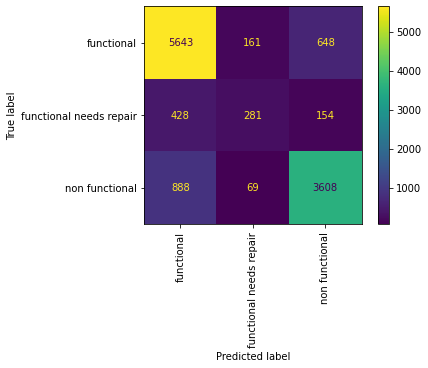

In [44]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, X_val, y_val, values_format='.0f', xticks_rotation='vertical')